In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
working_dir = os.path.expanduser('~/workspace/theislab/mubind/docs/notebooks/scatac')
if os.path.exists(working_dir):
    os.chdir(working_dir)

In [3]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [4]:
import scanpy as sc

In [5]:
# create a backup with neighbors+umap included
adata_updated_path = '../../../../../epiScanpy/docs/tutorials/write/buenrostro_pbmc.h5ad'
adata = sc.read_h5ad(adata_updated_path)


In [6]:
adata.shape

(1722, 122511)

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


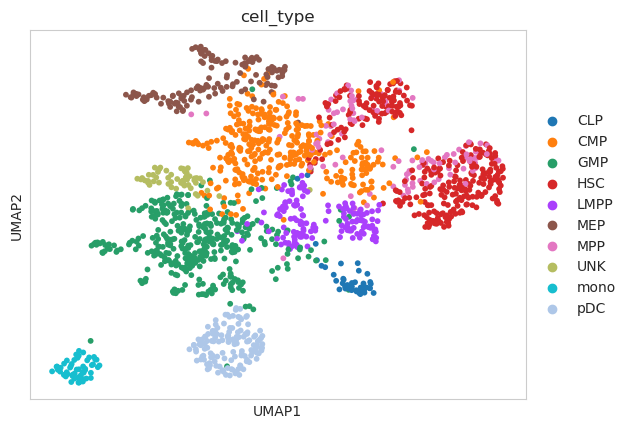

In [7]:
sc.pl.umap(adata, color='cell_type')

In [8]:
adata.shape

(1722, 122511)

In [9]:
ad = mb.pp.sample_anndata(adata, n_sample_obs=min(5000, adata.shape[0]), n_sample_var=5000)

### This extension is needed to make peaks homogeneous, and avoid long peaks

In [37]:
ad.layers['binary'].max(axis=1).min()

1.0

In [11]:
ad.var['chr'] = ad.var_names.str.split('_').str[0]
ad.var['start'] = ad.var_names.str.split('_').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('_').str[2].astype(int)

In [12]:
extend = 50
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'].astype(str) + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)


### Get sequences from fasta files

In [13]:
n_seqs = max(len(ad.var_names), 750)# adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='hg38', uppercase=True)
keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

/tmp/tmp8umgr01a
genome hg38 False
options
/mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa
True /mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa
running bedtools...
bedtools getfasta -fi /mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa -bed /tmp/tmp8umgr01a -fo /tmp/tmp_kkbcqfj


Feature (chr1:249117790-249117890) beyond the length of chr1 size (248956422 bp).  Skipping.
Feature (chr1:249203408-249203508) beyond the length of chr1 size (248956422 bp).  Skipping.
Feature (chr10:134136381-134136481) beyond the length of chr10 size (133797422 bp).  Skipping.
Feature (chr10:134148797-134148897) beyond the length of chr10 size (133797422 bp).  Skipping.
Feature (chr10:134221622-134221722) beyond the length of chr10 size (133797422 bp).  Skipping.
Feature (chr10:134237053-134237153) beyond the length of chr10 size (133797422 bp).  Skipping.
Feature (chr10:134251086-134251186) beyond the length of chr10 size (133797422 bp).  Skipping.
Feature (chr10:134260391-134260491) beyond the length of chr10 size (133797422 bp).  Skipping.
Feature (chr10:134351714-134351814) beyond the length of chr10 size (133797422 bp).  Skipping.
Feature (chr10:134360501-134360601) beyond the length of chr10 size (133797422 bp).  Skipping.
Feature (chr10:134401994-134402094) beyond the length 

### Preparation of training data

In [42]:
# use the raw counts across cells
next_data = pd.DataFrame(ad.layers['binary'].T.A) # sparse.from_spmatrix(counts.A)
next_data['var'] = next_data.var(axis=1)
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
print(next_data.shape)

(4928, 1723)


In [43]:
next_data.index.value_counts()

NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN    6
ACAGGATAGGTGGAGAAACACATGAAGTACAACTGCAGTGGGTTATAAAAAACGGCCTTTCGAGTTGAGCAATAAATTCGTTCAAGCAGCCATTCTGAAG    1
CTCCTAATAAAGCAGTAATAAGAACCACCCCCTACCCTGCCCCCACGCACATATTCTACACAGCTGGATGACTTTCCCTTCCTGCCCAAACCGCAGGAGA    1
CTCCATTCTTGAGTTACTTCACTTAGAATAATGGTCTCTGGTTCCATCAAAGTTGCTGCAAATGCCATTATTTTGTTTCTTTTTATGGCTGAGTAATATT    1
ACAGACTGGCAGTAGCAGATAATGCTGCTCTTGGACTTCAAAGAAAGGCGACATTTCTAACCTCTGGTTTACAAATGTACTTCTGGTTTCCAGGGAAAAC    1
                                                                                                       ..
ACGTGGTCATAGGATGACAGGAACGCGTATGTGTGGCTGAGGGCAGAGCGCTCCCTGGGTGCTGTGGTCTGAATGTTTGTGTCTCCTCAAATCCACATGT    1
CTTCCCAACTTGATATCCAGATTCAATGTAATCCTAATAAAAATCTCAGGAAGTTATTTTGTGGATATTGACAAACTGATTCTAAAGTTTGTATGGAGAG    1
AATGTGCTTCTAAGGGCAGGGAGAGCAAATATGCTGTTCTTTGACGGCAAATTATTCTTTTTTTAGTTCTTCAGTGGAAGTGAGAAGTCTTGTCCCTGTT    1
CAGCCCTTGGGTCCCTCCACTTCCTCTTCTCTTCGCTATCTCTGCT

In [57]:


# selection of cells based on overall var score
n_cells = ad.shape[0]
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]
# next_data = next_data.head(10000)

next_data = next_data[~next_data.index.str.contains('N')]

next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']
df = next_data_sel.copy() # sample
print(next_data_sel.shape)


(1722, 1722)


In [58]:
df

,0,1,2,3,4,5,6,7,8,9,...,1712,1713,1714,1715,1716,1717,1718,1719,1720,1721
seq,,,,,,,,,,,,,,,,,,,,,
AAAGTTATAAGCAACCAGTCCTCTGGCTAACCTTGCCAGCTGTATAAGAATCTGTATTAAAGGAAGCTTTGCTCCTACCACTTTACCAAGCCCGTAGAAA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
GAGGAAGGAGTAGATAAGGACTGCTGCTTGAAAGTGTGTGTGGTGAGGGATATAAGGGTGGAGAGAAAAAGGGCAGTAGGAAGACTAGGTAGAATGGGGG,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
GCACCTCCTGGTCCCCTATGAAGTCCCAAAGGATAAATTTCTTTGAGAATCTGGTGCTCAGGGCAAAATATGTACCTCCTGAGGAAGTTATTTGCTTCCT,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
AATGACTGACTTAAAATCTTCTAGGAACCAAGCTGACATTAGTTTCTGTTGTTGGACCAATTCACTGCCTACCTCTATGTGACTGCTAAGTTTGTTTTTC,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
TGCCTCACAACCCTGTGTGTTCTTCCCTCTGCCTGAAATAATCTTTTACCTATAATCCTTCTGGTCCCTTCTTCATTCATTTCTTTGCTCAGTTTTAGTA,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGAATATGCTTAAGTTATCTTCACCATAAAAAGAAGGGTGTTGCGGGAAGCAAACATTATATGTCACTTAATTCTGATTGACGAACGGTGGAAAGTTTAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
CTCCACTCCAGTCTGGACGACAGAGCAAGACGCTGCTCGAAAAAAAAAAAAAAAATAGCCTAGAGGGAAAGGCCTAGGTTTGCCTGCTCTCCCTGAGGCT,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCATCCTGTTGCCCATAAGATAAACAGCAAGCATCTTAGCATGGCGGGATCCAGGTGCAGACCTTTTGAGCCACCCGCTGCCCCCAGCCTCCATGGACAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# enr series = False indicates that everything is independent.
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)

In [60]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)

In [61]:
criterion = mb.tl.PoissonLoss()
n_kernels = 2
w = [20 for r in range(n_kernels)]
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=False,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None).cuda()


### Include kNN into the model

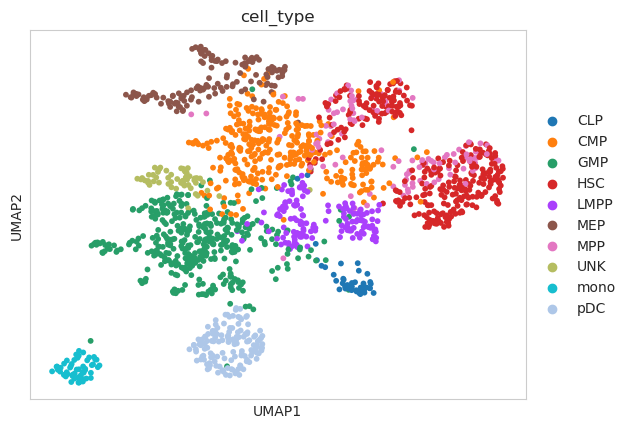

In [62]:
sc.pl.umap(ad, color='cell_type')

In [63]:
model.prepare_knn(ad)

In [64]:
model = model.cuda()

In [65]:
import torch.optim as topti


In [66]:
import warnings
warnings.filterwarnings("ignore")

In [67]:
model

Multibind(
  (padding): ConstantPad2d(padding=(19, 19, 0, 0), value=0.25)
  (binding_modes): BindingModesSimple(
    (conv_mono): ModuleList(
      (0): None
      (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
      (3): Conv2d(1, 1, kernel_size=(4, 20), stride=(1, 1), bias=False)
    )
    (conv_di): ModuleList(
      (0): None
    )
  )
  (activities): ActivitiesLayer(
    (log_activities): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 1x1722 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 1x1722 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTensor of size 1x1722 (GPU 0)]
        (3): Parameter containing: [torch.cuda.FloatTensor of size 1x1722 (GPU 0)]
    )
  )
  (selex_module): SelexModule()
  (criterion): PoissonLoss()
)

In [68]:
model, best_loss = model.optimize_iterative(train, n_epochs=[500, 200, 200, 200], show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0, 1, 1],
                                            opt_kernel_length=[0, 0, 1, 1],
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            # skip_kernels=range(2, 4),
                                            n_batches=1, n_rounds=df.shape[1], num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20, 20], r2_per_epoch=True,
                                            early_stopping=50, log_each=10, w=25, max_w=25) #  target_dim=train.dataset.signal.shape[1])

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 500 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
Epoch: 11, Loss: 129.180939, R2: 0.10,  best epoch: 9,  secs per epoch: 0.399 s,  secs epoch*1k trials: 0.232s
Epoch: 21, Loss: 129.175995, R2: 0.11,  best epoch: 13,  secs per epoch: 0.372 s,  secs epoch*1k trials: 0.216s
Epoch: 31, Loss: 129.176109, R2: 0.12,  best epoch: 28,  secs per epoch: 0.378 s,  secs epoch*1k trials: 0.219s
Epoch: 41, Loss: 129.173790, R2: 0.12,  best epoch: 36,  secs per epoch: 0.391 s,  secs epoch*1k trials: 0.227s
Epoch: 51, Loss: 129.175293, R2: 0.12,  best epoch: 47,  secs per epoch: 0.405 s,  secs epoch*1k 

RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment

In [ ]:
r2 = mb.tl.scores(model, train, by='batch')
print("R^2:", r2)


In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=2, show=True)
plt.show()


### Here we attempt to visualize the log_dynamic scores

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')

In [ ]:
# dyn_score
dyn_score = mb.tl.dynamic_score(model)
dyn_score_scaled = (dyn_score - dyn_score.min()) / (dyn_score.max() - dyn_score.min())
ad.obs['dynamic_score'] = dyn_score_scaled

In [ ]:
ad.obs['dynamic_score_cluster'] = np.where(dyn_score_scaled > dyn_score_scaled.mean(), 'dynamic', 'static')
mu, sigma = dyn_score.mean(), dyn_score.std()
zscore = ((dyn_score - mu) / sigma)
z1 = np.where(zscore > 1, 'dynamic', 'static')
z2 = np.where(zscore > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dyn_score)
plt.xlabel('dynamic score (normalized)')


In [ ]:
sc.tl.umap(ad)

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(ad, color=['dynamic_score', 'cell_type'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [ ]:
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')

In [ ]:
sc.pl.embedding_density?

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group=['dynamic', 'static'], color_map='Reds') # basis='umap', groupby='dynamic_score_cluster')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group=['dynamic', 'static'], color_map='Blues') # basis='umap', groupby='dynamic_score_cluster')
# sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=13)

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=5, n_cols=12) # n_cols=len(reduced_groups))


In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)
